In [1]:
!pip install qrcode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 7.6 MB/s eta 0:00:00


In [26]:
import qrcode
from PIL import Image
def generate_qrcode(content):
  qr = qrcode.QRCode(
      version=1,
      error_correction=qrcode.constants.ERROR_CORRECT_H,
      box_size=16,
      border=0,
  )
  qr.add_data(content)
  qr.make(fit=True)
  img = qr.make_image(fill_color="Black", back_color="White")

  offset_min = 8 * 16
  w, h = img.size
  w = (w+255+offset_min) // 256*256
  h = (h+255+offset_min) // 256*256

  if w>1024:
    raise ValueError("Qr size excided")
  bg = Image.new('L', (w,h), 255)

  coords = (
      (w - img.size[0]) // 2 // 16 * 16,
      (h - img.size[1]) // 2 // 16 * 16
  )
  bg.paste(img, coords)
  return bg

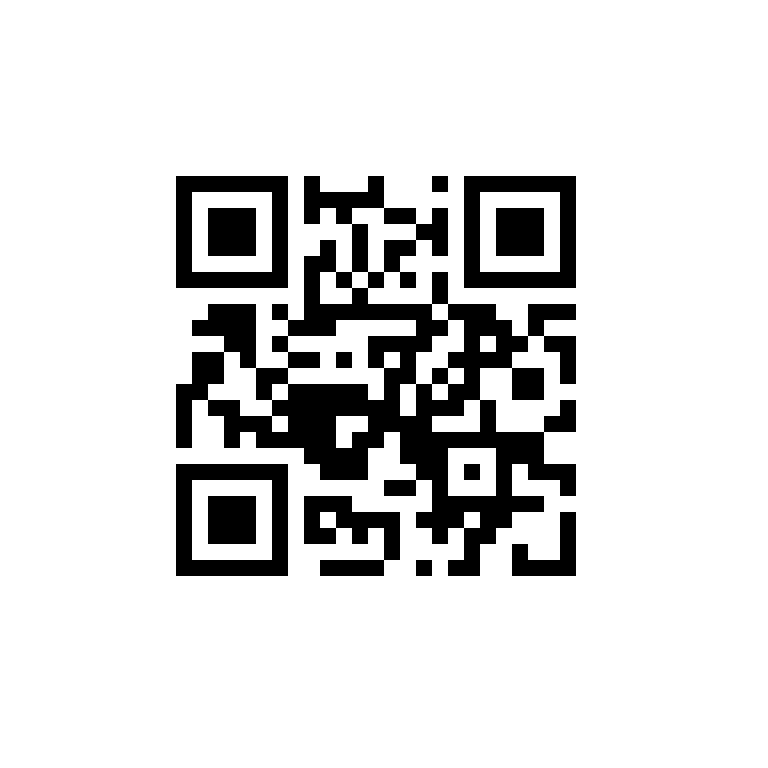

In [27]:
generate_qrcode('i like u')

In [16]:
!pip install diffusers transformers accelerate torch xformers


In [28]:
from urllib.parse import urlencode
from urllib.request import urlopen
import torch
from PIL import Image
from diffusers import StableDiffusionControlNetImg2ImgPipeline, ControlNetModel, DDIMScheduler
from diffusers.utils import load_image

In [29]:
controlnet = ControlNetModel.from_pretrained("DionTimmer/controlnet_qrcode-control_v1p_sd15",
                                             torch_dtype=torch.float16)

In [30]:
pipe = StableDiffusionControlNetImg2ImgPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnet,
    safety_checker=None,
    torch_dtype=torch.float16
).to("cuda")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet_img2img.StableDiffusionControlNetImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [31]:
pipe.enable_xformers_memory_efficient_attention()
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()


In [32]:
def resize_for_condition_image(input_image: Image, resolution: int):
    input_image = input_image.convert("RGB")
    W, H = input_image.size
    k = float(resolution) / min(H, W)
    H *= k
    W *= k
    H = int(round(H / 64.0)) * 64
    W = int(round(W / 64.0)) * 64
    img = input_image.resize((W, H), resample=Image.LANCZOS)
    return img

In [33]:
source_image = load_image("/content/download (54).png")

In [34]:
init_image = load_image("/content/cropped.jpg")
condition_image = resize_for_condition_image(source_image, 768)
init_image = resize_for_condition_image(init_image, 768)
generator = torch.manual_seed(123121231)

  0%|          | 0/135 [00:00<?, ?it/s]

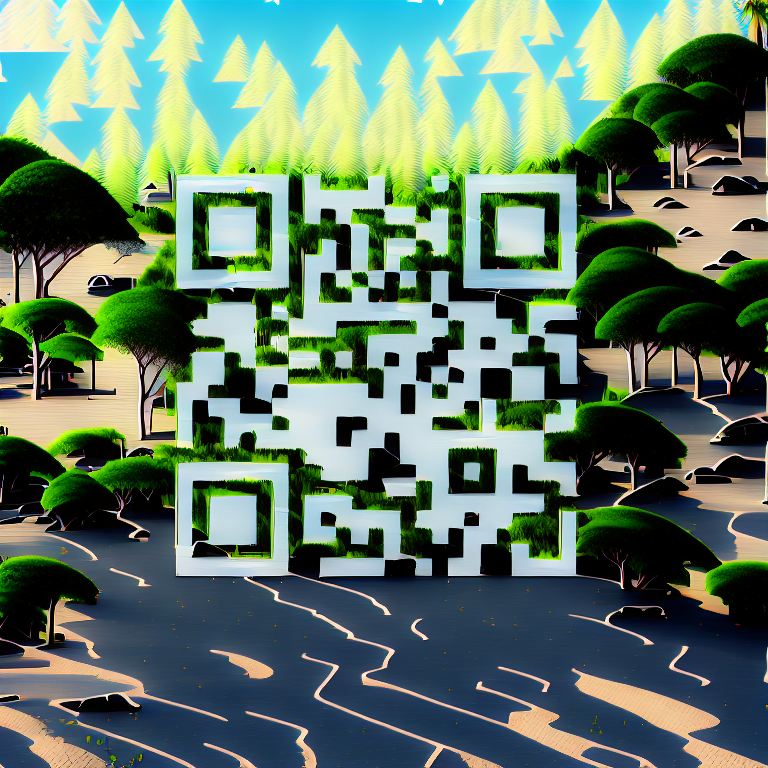

In [35]:
image = pipe(prompt="nature view. beach and beside a house with trees in front of house. looking attractive",
             negative_prompt="ugly, disfigured, low quality, blurry, nsfw",
             image=init_image,
             control_image=condition_image,
             width=768,
             height=768,
             guidance_scale= 10,
             controlnet_conditioning_scale= 3.5,
             generator=generator,
             strength = 0.9,
             num_inference_steps=150,

            )

image.images[0]